## Detectability 


We are interested in how detectable a GW is using PTA + state space method

We can use our state-space tools  to try to solve the problem of GW detection with a PTA i.e. _"Is there evidence of a GW in my data?_. 

We can frame this as a model selection procedure where we have two models/hypotheses:


* **Null Model** $M_0$. There is no GW in the data. In this case the measurement model of the Kalman filter simply returns the frequency states i.e. $g(t,\theta)= 0$
* **Alternative model** $M_1$. There is a GW in the data. The measurement model uses the full expression for $g(t,\theta)$


In order to accept the alternative hypothesis $M_1$ over $M_0$ there are two approaches we could take:

1. The first is a fully Bayesian search over all the parameters for each model, calculating the evidence for each model and then determining the Bayes ratio. This is perhaps the most consistent way, but it is obviously expensive and at this stage we are keen to explore how detectability varies with e.g. GW strain.

	
2. The second method is to recognize that $M_0$ and $M_1$ are hierarchically nested models and we can perform a likelihood ratio test. That is, given the maximum likelihood estimators $\hat{\theta}$ of the true parameters $\theta$, the likelihood of each model can be calculate. These likelihoods are just  point estimates of the Bayes factor numerator/denominators. They can then be compared via the likelihood ratio $\Lambda$. 

	
Given the cheap cost we proceed with the second method.


### Likelihood ratio test
For the likelihood ratio test we do not perform any kind of maximum likelihood search over the parameters for each of the models. Instead we just artificially set the maximum likelihood estimators to be equal to the true parameters of the system i.e. $\hat{\theta} = \theta$. We assume that any maximum likelihood algorithm would converge to these parameters. This is obviously an oversimplification but will serve our purposes for now.


Interpreting the likelihood ratio $\Lambda$ also needs some consideration, since we have to account for the increased model complexity of $M_1$. Bayes factors penalise complexity by construction since one must integrate over a larger parameter space. 

There are many different ways to do this:

* AIC
* BIC
* Wilks Theorem
* ...


In practice we will use different criteria to check they agree.

Lets quickly review the number of parameters in each model:

* The null model solely has parameters that correspond to the pulsars. $f_0$, $\dot{f}$, $\gamma$, $d$

* The null model has all the pulsar parameters, plus 7 additional GW parameters


For now we will treat $\sigma_p$ and $\sigma_m$ as  single parameters that are shared across $N$ pulsars


In [1]:
%load_ext autoreload
%autoreload 2

import sys
try:
    sys.path.remove("../py_src") # Hacky way to add higher directory to python modules path. 
except:
    pass
sys.path.append("../py_src") # Means that I dont have to make src/ a proper python package


from system_parameters import SystemParameters
from pulsars import Pulsars

from synthetic_data import SyntheticData
from plotting import plot_statespace,plot_all
from model import LinearModel
from kalman_filter import KalmanFilter
from bilby_wrapper import BilbySampler
from priors import priors_dict,bilby_priors_dict

Defining the priors dict. Number of pulsars =  47
GW strain =  0.01
after first update
float64 float64 float64
after first update
float64 float64 float64


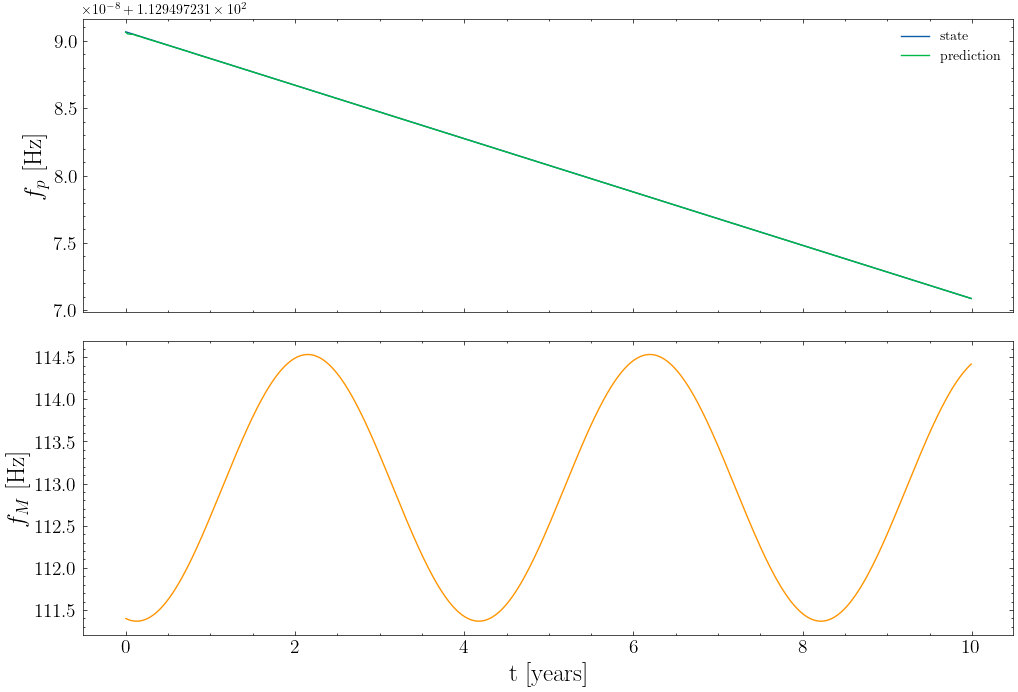

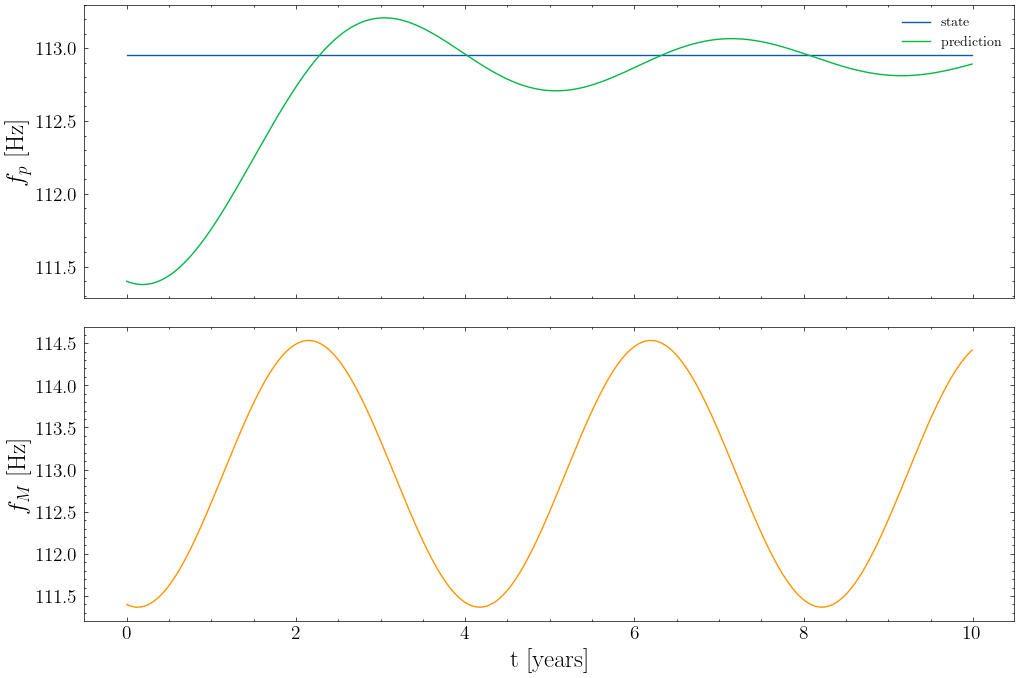

Likelihood ratio =  5.039633775326549e+24


In [2]:
P    = SystemParameters()       #define the system parameters as a class
PTA  = Pulsars(P)               #setup the PTA
data = SyntheticData(PTA,P) #generate some synthetic data


#Define the model 
model = LinearModel

#Initialise the Kalman filter
KF = KalmanFilter(model,data.f_measured,PTA)

# Run the KFwith the correct parameters
true_parameters = priors_dict(PTA,P)
model_likelihood, model_state_predictions = KF.likelihood_and_states(true_parameters)

null_model_likelihood, null_model_state_predictions = KF.null_likelihood_and_states(true_parameters)

plot_all(PTA.t, data.intrinsic_frequency, data.f_measured, model_state_predictions, 5)
plot_all(PTA.t, data.intrinsic_frequency, data.f_measured, null_model_state_predictions, 5)

print("Likelihood ratio = ", model_likelihood - null_model_likelihood)


In [37]:
import numpy as np
def get_likelihood_ratios(h):

    P    = SystemParameters(h=h,NF=np.float64,σp=1e-10,Npsr=0)       #define the system parameters as a class
    PTA  = Pulsars(P)               #setup the PTA
    data = SyntheticData(PTA,P) #generate some synthetic data


    #Define the model 
    model = LinearModel

    #Initialise the Kalman filter
    KF = KalmanFilter(model,data.f_measured,PTA)

    # Run the KFwith the correct parameters
    true_parameters = priors_dict(PTA,P)


    model_likelihood, model_state_predictions = KF.likelihood_and_states(true_parameters)
    null_model_likelihood, null_model_state_predictions = KF.null_likelihood_and_states(true_parameters)

    
    TS = model_likelihood - null_model_likelihood

    return TS



In [38]:
%%capture
import numpy as np

xx = np.logspace(-18,-3,100)
yy = np.zeros_like(xx)

i = 0
for h in xx:
    TS = get_likelihood_ratios(h)
    yy[i] = TS
    i +=1

In [21]:
from plotting import SNR_plots

Cutoff value =  4.831889501785299e-11


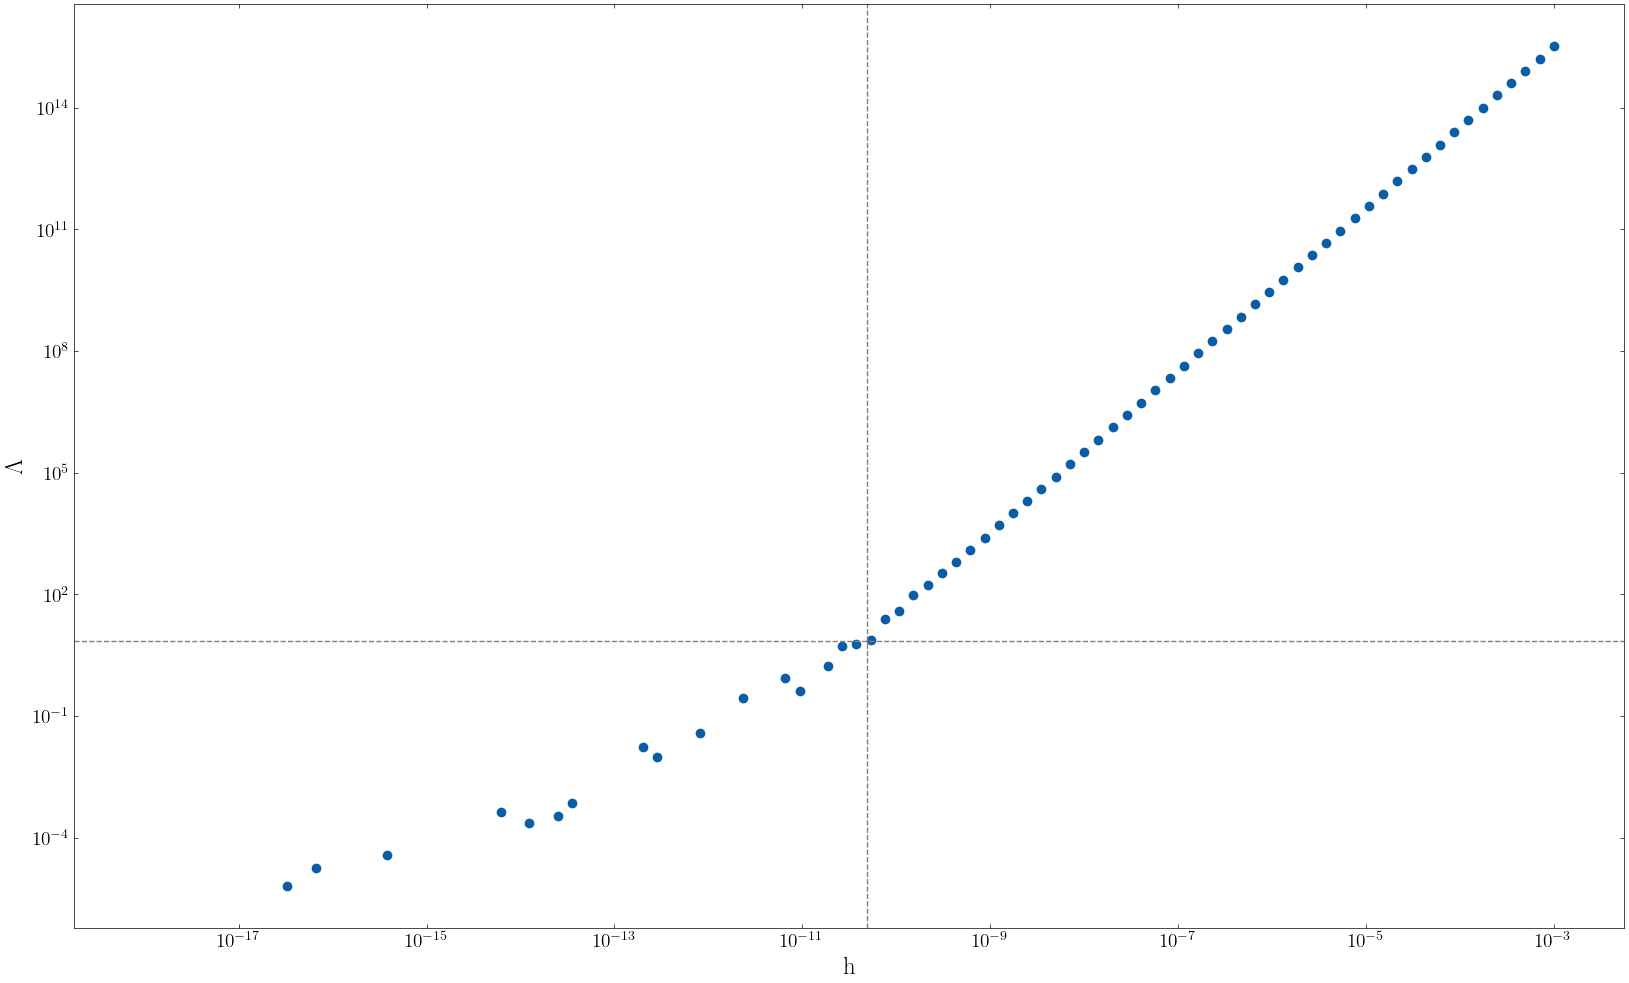

In [39]:
SNR_plots(xx,yy,xlabel="h")

Cutoff value =  3.814206262744028e-14


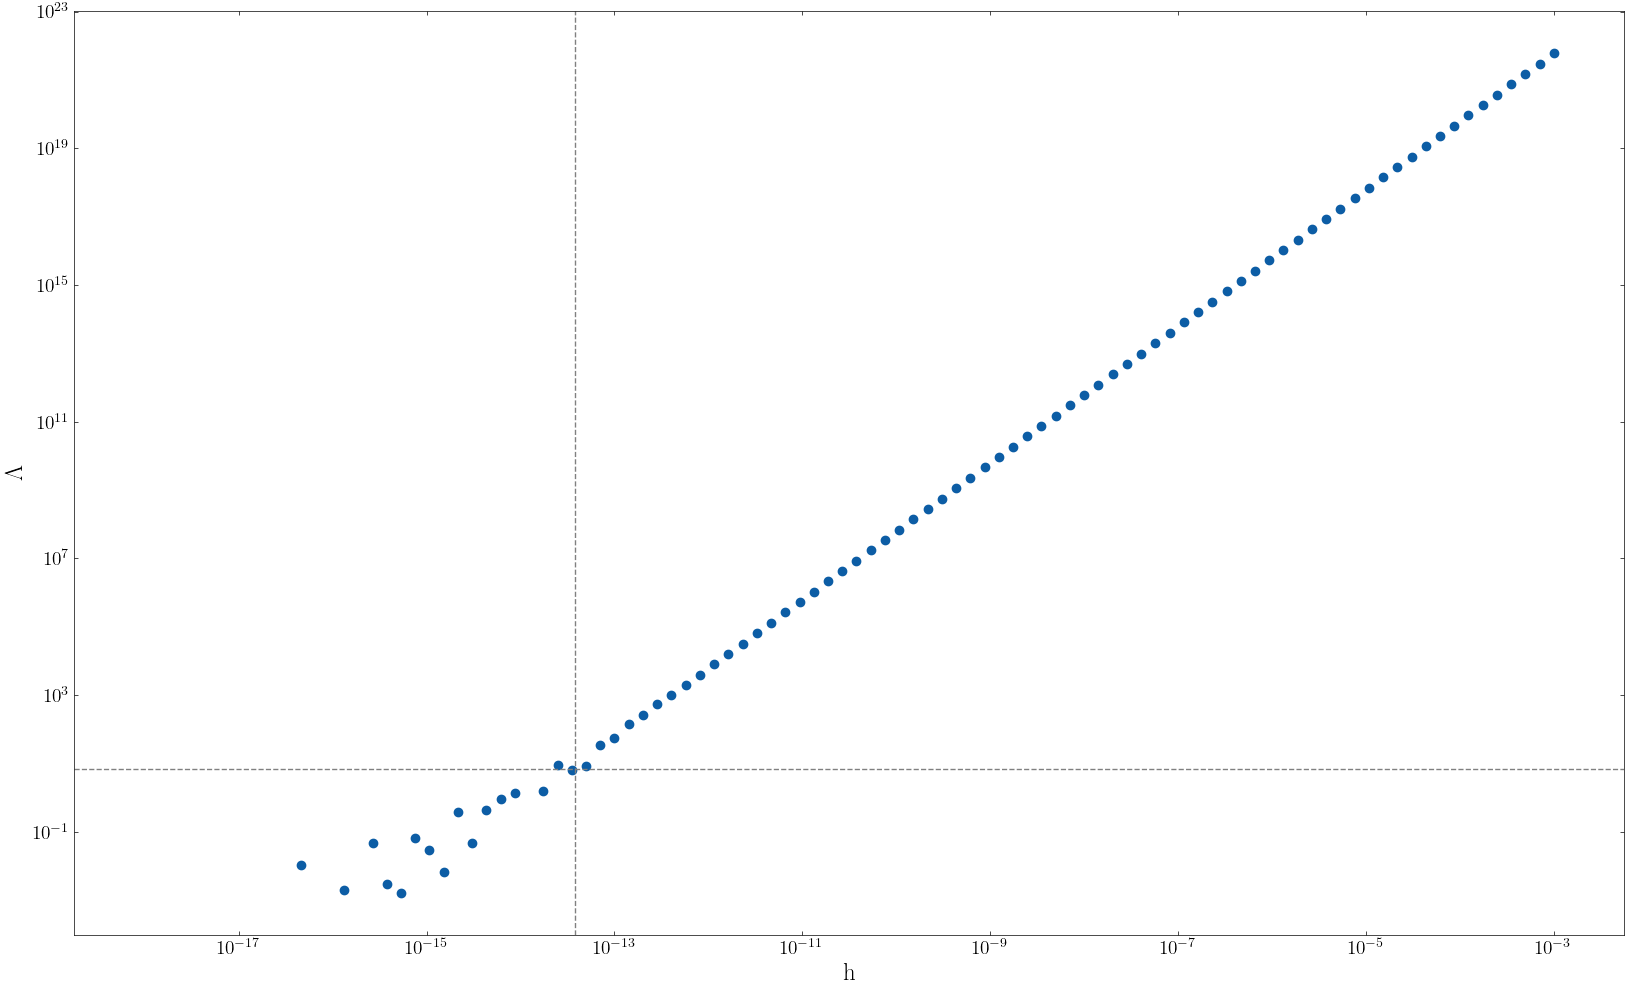

In [32]:
SNR_plots(xx,yy,xlabel="h")

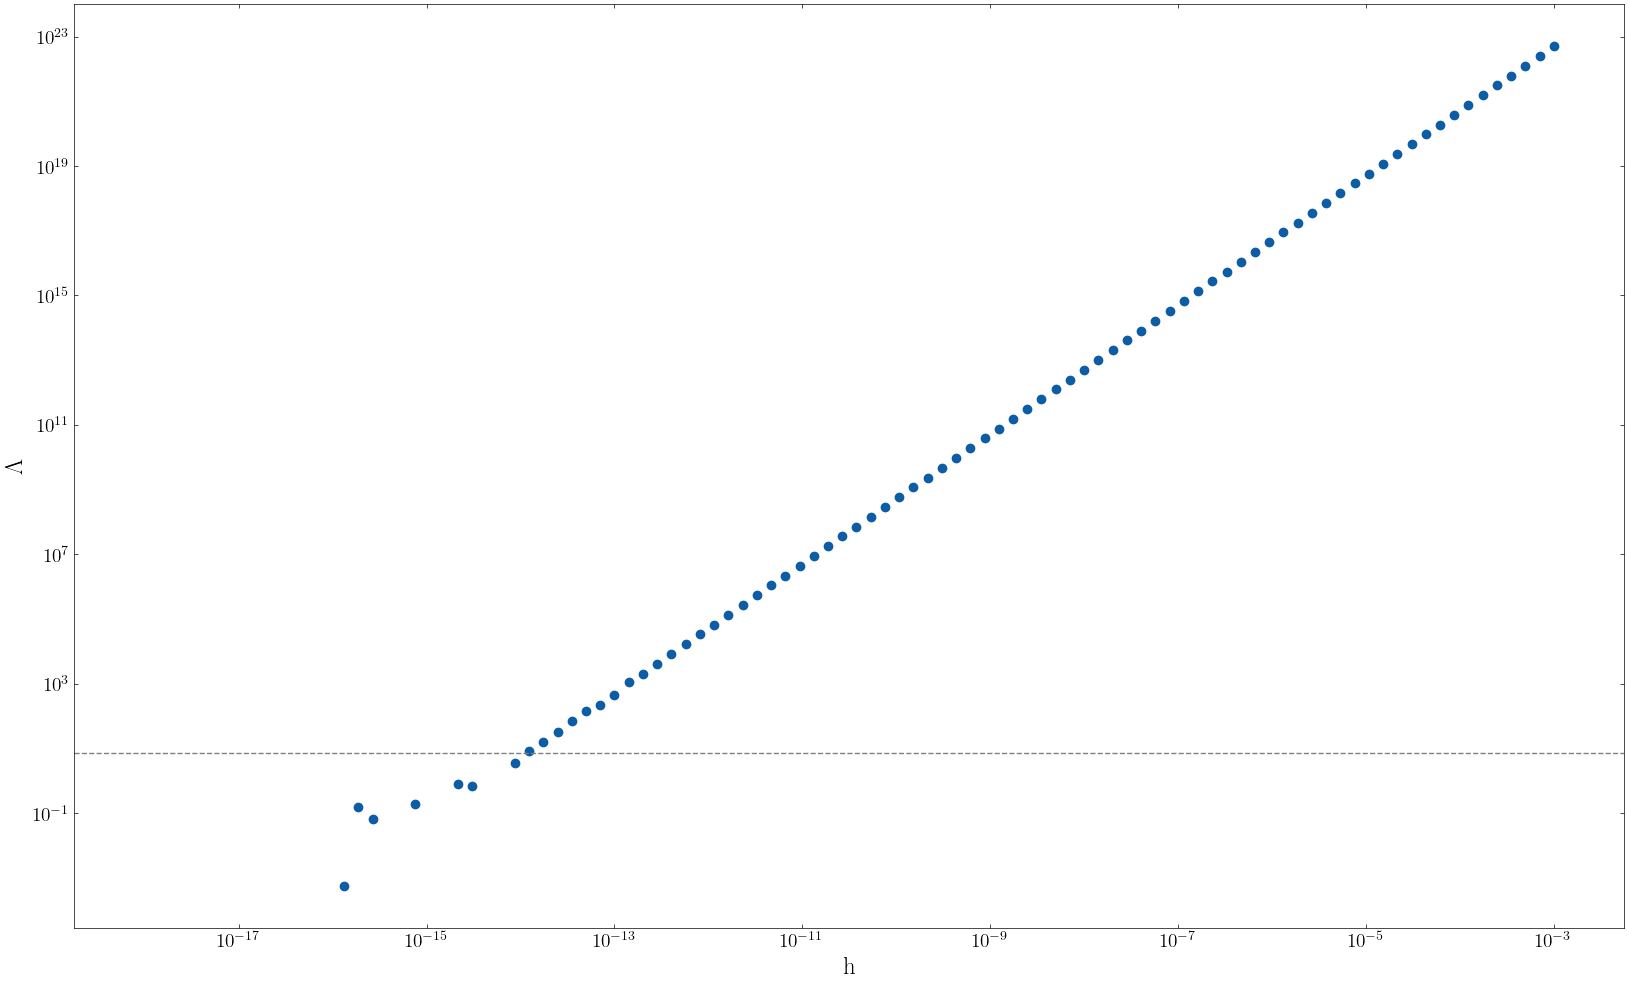

In [23]:
SNR_plots(xx,yy,xlabel="h")

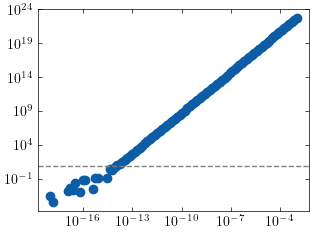

In [15]:
import matplotlib.pyplot as plt 
plt.scatter(xx,yy)
plt.xscale('log')
plt.yscale('log')
plt.axhline(7,linestyle='--', c='0.5')

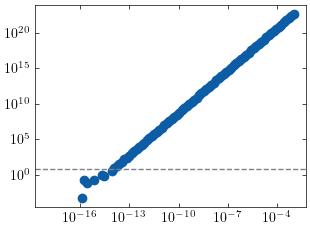

In [18]:
import matplotlib.pyplot as plt 
plt.scatter(xx,yy)
plt.xscale('log')
plt.yscale('log')
plt.axhline(7,linestyle='--', c='0.5')